In [1]:
import scipy.io as sio
import numpy as np
from scipy.linalg import toeplitz
from scipy.linalg import eigh
from copy import deepcopy
from scipy.optimize import minimize
from scipy.stats import truncnorm
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import data_generator
import ESPRIT
import QPE
import QCELS
import QMEGS

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def generate_ts_distribution(T,N,gamma):
    """ Generate time samples from truncated Gaussian
    Input:
    
    T : variance of Gaussian
    gamma : truncated parameter
    N : number of samples
    
    Output: 
    
    t_list: np.array of time points
    """
    t_list=truncnorm.rvs(-gamma, gamma, loc=0, scale=T, size=N)
    return t_list

def generate_Z(spectrum,population,T,N,gamma):
    """ Generate Z samples for a given T,N,gamma
    Input:
    
    spectrum: np.array of eigenvalues
    population: np.array of overlap
    T : variance of Gaussian
    N : number of time samples
    gamma : truncated parameter
    
    Output: 
    
    Z_est: np.array of Z output
    t_list: np.array of time points
    T_max: maximal running time
    T_total: total running time
    """
    t_list = generate_ts_distribution(T,N,gamma)
    N_list = np.ones(len(t_list))
    T_max = max(np.abs(t_list))
    T_total = sum(np.multiply(np.abs(t_list),N_list))
    Z_est, _ , _ =data_generator.generate_Hadamard_test_data(spectrum,population,t_list,N_list)
    return Z_est, t_list, T_max, T_total

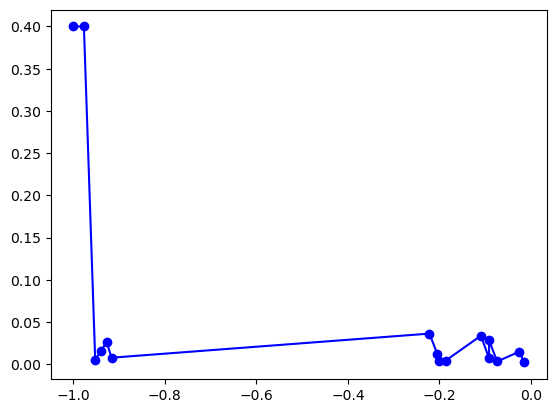

dominent gap= 0.02324231000729793


In [3]:
#Test Hubbard
L = 4
J = 1.0
U = 10.0
mu = 0.0
N_up = L // 2
N_down = L - N_up
p_list=np.array([0.4,0.4])
d=2**L

spectrum, population=data_generator.generate_initial_Hubbard(L,J,U,mu,N_up,N_down,p_list,d)
print('dominent gap=',spectrum[1]-spectrum[0])

In [4]:
N_rep=5 #number of different trying
N_rep_ESPRIT=5
spectrum_per=np.zeros((len(spectrum),N_rep))
for n in range(N_rep):
   #random perturb to avoid coincidence
   spectrum_per[:,n]=spectrum+np.random.uniform(-1,1)*0.005

# Test QMEGS

In [5]:
T_list=np.array([200,400,800,1600,3200,6400,12800])
N=500
K_QMEGS=2
K_dominant=2
alpha=5
gamma=1
error_QMEGS=np.zeros(len(T_list),dtype='float')
T_total_QMEGS=np.zeros(len(T_list),dtype='float')
for n in range(N_rep):
    for k in range(len(T_list)):
        T_max=T_list[k]
        d_x=0.05/T_max
        Z_est,t_list, _, T_total = generate_Z(spectrum_per[:,n],population,T_max,N,gamma)
        T_total_QMEGS[k]+=sum(np.abs(t_list))
        output_energy = QMEGS.QMEGS_new(Z_est, d_x, t_list, K_QMEGS, alpha, T_max)
        output_energy = np.sort(output_energy)
        ##---measure error--##
        index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
        dominant_energy=np.zeros(K_dominant,dtype=float)
        dominant_weight=np.zeros(K_dominant,dtype=float)
        error_temp=0
        for l in range(K_dominant):
                dominant_energy[l]=spectrum_per[index_list[l],n]
                error_temp=max(error_temp,min(np.abs(dominant_energy[l]-output_energy)))
        error_QMEGS[k]+=error_temp
        if n==0:
            print('Tmax=',gamma*T_max)
            print('Output of QMEGS energy=',output_energy)
            print('True dominant=',np.sort(dominant_energy))
T_total_QMEGS=T_total_QMEGS/N_rep
error_QMEGS=error_QMEGS/N_rep

Tmax= 200
Output of QMEGS energy= [-0.98434265 -0.98309265]
True dominant= [-1.00375825 -0.98051594]
Tmax= 400
Output of QMEGS energy= [-1.00296765 -0.98096765]
True dominant= [-1.00375825 -0.98051594]
Tmax= 800
Output of QMEGS energy= [-1.00403015 -0.98028015]
True dominant= [-1.00375825 -0.98051594]
Tmax= 1600
Output of QMEGS energy= [-1.00390515 -0.98059265]
True dominant= [-1.00375825 -0.98051594]
Tmax= 3200
Output of QMEGS energy= [-1.00385828 -0.98048328]
True dominant= [-1.00375825 -0.98051594]
Tmax= 6400
Output of QMEGS energy= [-1.00378797 -0.98051453]
True dominant= [-1.00375825 -0.98051594]
Tmax= 12800
Output of QMEGS energy= [-1.00377234 -0.98051843]
True dominant= [-1.00375825 -0.98051594]


# Test QPE

In [12]:
N_QPE=30
error_QPE=np.zeros(len(T_list),dtype='float')
T_total_QPE=np.zeros(len(T_list),dtype='float')
for n in range(N_rep):
    for k in range(len(T_list)):
        T_max=T_list[k]
        output_energy = QPE.QPE(spectrum_per[:,n],population,T_max,N_QPE)
        T_total_QPE[k]+=T_max*N_QPE
        ##---measure error--##
        error_QPE[k]+=np.abs(spectrum_per[0,n]-output_energy)
        if n==0:
            print('Tmax=',T_max)
            print('Output of QPE energy=',output_energy)
            print('True ground=',spectrum_per[0,n])        
T_total_QPE=T_total_QPE/N_rep
error_QPE=error_QPE/N_rep

Tmax= 200
Output of QPE energy= -2.199114857512855
True ground= -1.0037582491824792
Tmax= 400
Output of QPE energy= -1.0681415022205294
True ground= -1.0037582491824792
Tmax= 800
Output of QPE energy= -1.0053096491487334
True ground= -1.0037582491824792
Tmax= 1600
Output of QPE energy= -1.0053096491487334
True ground= -1.0037582491824792
Tmax= 3200
Output of QPE energy= -1.0053096491487334
True ground= -1.0037582491824792
Tmax= 6400
Output of QPE energy= -1.004327901444487
True ground= -1.0037582491824792
Tmax= 12800
Output of QPE energy= -1.0038370275923634
True ground= -1.0037582491824792


# Test ESPRIT

In [7]:
t_list=np.arange(max(T_list))
N_list=np.ones(len(t_list))
K_ESPRIT=2
K_dominant=2
nt_array=T_list
error_ESPRIT=np.zeros(len(nt_array),dtype='float')
T_total_ESPRIT=np.zeros(len(T_list),dtype='float')
for n in range(N_rep_ESPRIT):
    f_values,_,_=data_generator.generate_Hadamard_test_data(spectrum_per[:,n],
    population,t_list,N_list)
    for k in range(len(nt_array)):
        dt=1
        nt_effective=nt_array[k]
        #ESPRIT
        output_energy = ESPRIT.ESPRIT(f_values[:nt_effective], int(nt_effective/2), nt_effective, K_ESPRIT)
        T_total_ESPRIT[k]+=nt_effective*(nt_effective+1)/2
        ##---measure error--##
        index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
        dominant_energy=np.zeros(K_dominant,dtype=float)
        dominant_weight=np.zeros(K_dominant,dtype=float)
        error_temp=0
        for l in range(K_dominant):
            dominant_energy[l]=spectrum_per[index_list[l],n]
            error_temp=max(error_temp,min(np.abs(dominant_energy[l]-output_energy)))
        error_ESPRIT[k]+=error_temp
        if n==0:
            print('Tmax=',nt_effective*dt)
            print('Output of ESPRIT energy=',output_energy)
            print('True dominant=',np.sort(dominant_energy))
T_total_ESPRIT=T_total_ESPRIT/N_rep_ESPRIT
error_ESPRIT=error_ESPRIT/N_rep_ESPRIT

Tmax= 200
Output of ESPRIT energy= [-1.00098869  0.91671039]
True dominant= [-1.00375825 -0.98051594]
Tmax= 400
Output of ESPRIT energy= [-1.00372462 -0.98305782]
True dominant= [-1.00375825 -0.98051594]
Tmax= 800
Output of ESPRIT energy= [-1.00399387 -0.980279  ]
True dominant= [-1.00375825 -0.98051594]
Tmax= 1600
Output of ESPRIT energy= [-1.00384655 -0.98049608]
True dominant= [-1.00375825 -0.98051594]
Tmax= 3200
Output of ESPRIT energy= [-1.00376907 -0.98039874]
True dominant= [-1.00375825 -0.98051594]
Tmax= 6400
Output of ESPRIT energy= [-1.00375317 -0.98051526]
True dominant= [-1.00375825 -0.98051594]
Tmax= 12800
Output of ESPRIT energy= [-1.00374651 -0.98051865]
True dominant= [-1.00375825 -0.98051594]


# Test QCELS

In [8]:
def spectrum_organize(Output_QCELS): #combine opposite r but same \theta
    dis_threshold=0.01
    L=len(Output_QCELS)
    L=int(L/3)
    index_list=np.zeros(L, dtype='float')
    weight_rearrange=np.zeros(L, dtype='complex')
    indicator=np.zeros(L, dtype='float')
    for l in range(L): #combine eigenvalues with oppposite weight
        if indicator[l]==0:
           weight_rearrange[l]=Output_QCELS[3*l]+1j*Output_QCELS[3*l+1]
           fix_energy_check=Output_QCELS[3*l+2]
           for j in range(l+1,L): 
               if np.abs(Output_QCELS[3*j+2]-fix_energy_check)<dis_threshold:
                  weight_rearrange[l]+=Output_QCELS[3*j]+1j*Output_QCELS[3*j+1]
                  indicator[j]=1
        indicator[l]=1
        weight_rearrange[l]=np.abs(weight_rearrange[l])
    index_list=sorted(range(L),key= lambda k:weight_rearrange[k], reverse=True)
    dominant_energy=np.zeros(L, dtype='float')
    for l in range(L):
        dominant_energy[l]=Output_QCELS[3*index_list[l]+2]
    return dominant_energy

In [9]:
N_0 = 1000 #N_0
N = 500 #N
gamma=1
K_QCELS=2
T_total_QCELS=np.zeros(len(T_list),dtype='float')
error_QCELS=np.zeros(len(T_list),dtype='float')
for n in range(N_rep):
    for k in range(len(T_list)):
        T = T_list[k]
        T_0 = 200
        dominant_energy_estimate=np.zeros(K_QCELS)
        Output_QCELS, _, T_total = \
                 QCELS.qcels_multimodal(spectrum_per[:,n], population, T_0, T, N_0, N, gamma, K_QCELS, spectrum_per[0:2,n])#QCELS with time T
        output_energy=np.sort(spectrum_organize(Output_QCELS))
        T_total_QCELS[k]+=T_total
        ##---measure error--##
        index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
        dominant_energy=np.zeros(K_dominant,dtype=float)
        dominant_weight=np.zeros(K_dominant,dtype=float)
        error_temp=0
        for l in range(K_dominant):
            dominant_energy[l]=spectrum_per[index_list[l],n]
            error_temp=max(error_temp,min(np.abs(dominant_energy[l]-output_energy)))
        error_QCELS[k]+=error_temp
        if n==0:
            print('Tmax=',gamma*T)
            print('Output of QCELS energy=',output_energy)
            print('True dominant=',np.sort(dominant_energy))
T_total_QCELS=T_total_QCELS/N_rep
error_QCELS=error_QCELS/N_rep

Tmax= 200
Output of QCELS energy= [-1.00442485 -0.98179704]
True dominant= [-1.00375825 -0.98051594]
Tmax= 400
Output of QCELS energy= [-1.00370748 -0.98001367]
True dominant= [-1.00375825 -0.98051594]
Tmax= 800
Output of QCELS energy= [-1.00409744 -0.98024232]
True dominant= [-1.00375825 -0.98051594]
Tmax= 1600
Output of QCELS energy= [-1.0036477  -0.98061504]
True dominant= [-1.00375825 -0.98051594]
Tmax= 3200
Output of QCELS energy= [-1.00371036 -0.98048675]
True dominant= [-1.00375825 -0.98051594]
Tmax= 6400
Output of QCELS energy= [-1.00374633 -0.98046922]
True dominant= [-1.00375825 -0.98051594]
Tmax= 12800
Output of QCELS energy= [-1.00374929 -0.98052084]
True dominant= [-1.00375825 -0.98051594]


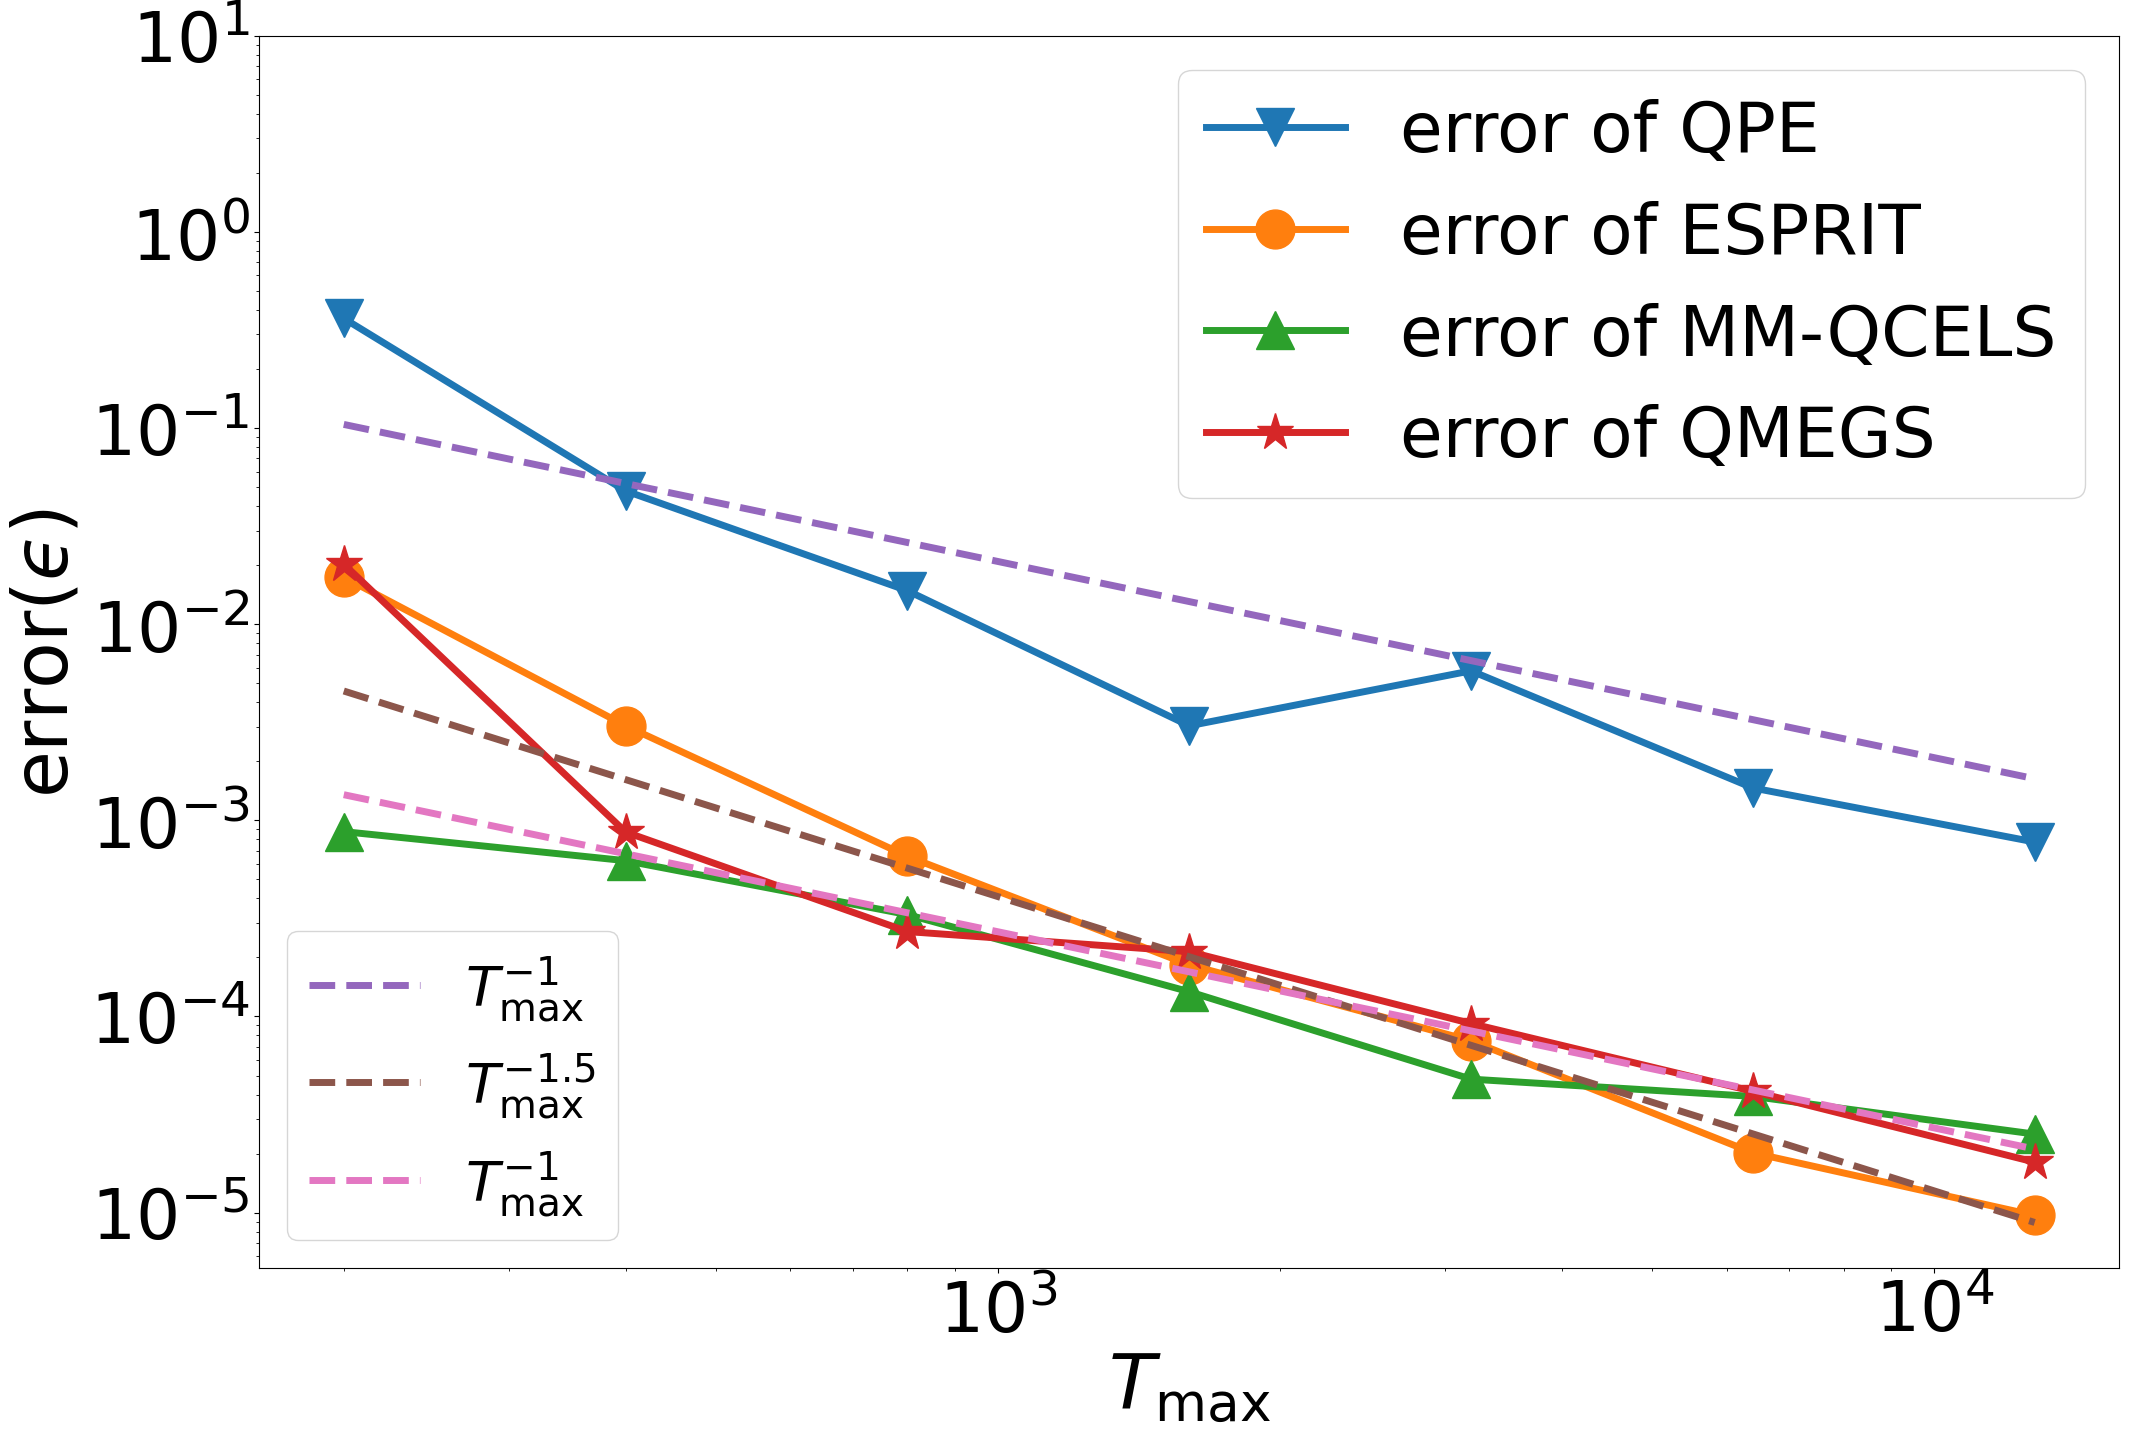

In [14]:
# Plotting the real and imaginary parts of f(t)
T_list=dt*nt_array
plt.figure(figsize=(24, 16))
plt.loglog(T_list, error_QPE, marker="v",markersize=28,
            linewidth=5, label='error of QPE')
plt.loglog(T_list, error_ESPRIT, marker="o",markersize=28,
           linewidth=5, label='error of ESPRIT')
plt.loglog(T_list, error_QCELS, marker="^",markersize=28,
           linewidth=5, label='error of MM-QCELS')
plt.loglog(T_list, error_QMEGS, marker="*",markersize=28,
           linewidth=5, label='error of QMEGS')
plt.loglog(T_list, np.dot(error_QPE,T_list)/T_list/len(error_QPE), 
            '--', linewidth=5, label=r'$T_{\max}^{-1}$')
# plt.loglog(T_list, np.dot(error_QCELS,T_list)/T_list/len(error_QCELS),
#            '--', linewidth=5, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list, np.dot(error_ESPRIT[2:],T_list[2:]**1.5)/T_list**1.5/len(error_ESPRIT[2:]), 
           '--', linewidth=5, label=r'$T_{\max}^{-1.5}$')
plt.loglog(T_list, np.dot(error_QMEGS[2:],T_list[2:])/T_list/len(error_QMEGS[2:]), 
           '--', linewidth=5, label=r'$T_{\max}^{-1}$')
plt.xlabel("$T_{\max}$",fontsize=55)
plt.ylabel("error($ϵ$)",fontsize=55)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
lines = plt.gca().get_lines()
include = [0,1,2,3]
legend1 = plt.legend([lines[i] for i in include],[lines[i].get_label() for i in include], 
                     fontsize=50,loc=1)
legend2 = plt.legend([lines[i] for i in [4,5,6]],[lines[i].get_label() for i in [4,5,6]], 
                     fontsize=40,loc=3)
plt.gca().add_artist(legend1)
plt.savefig('Hubbard_T_max.pdf')

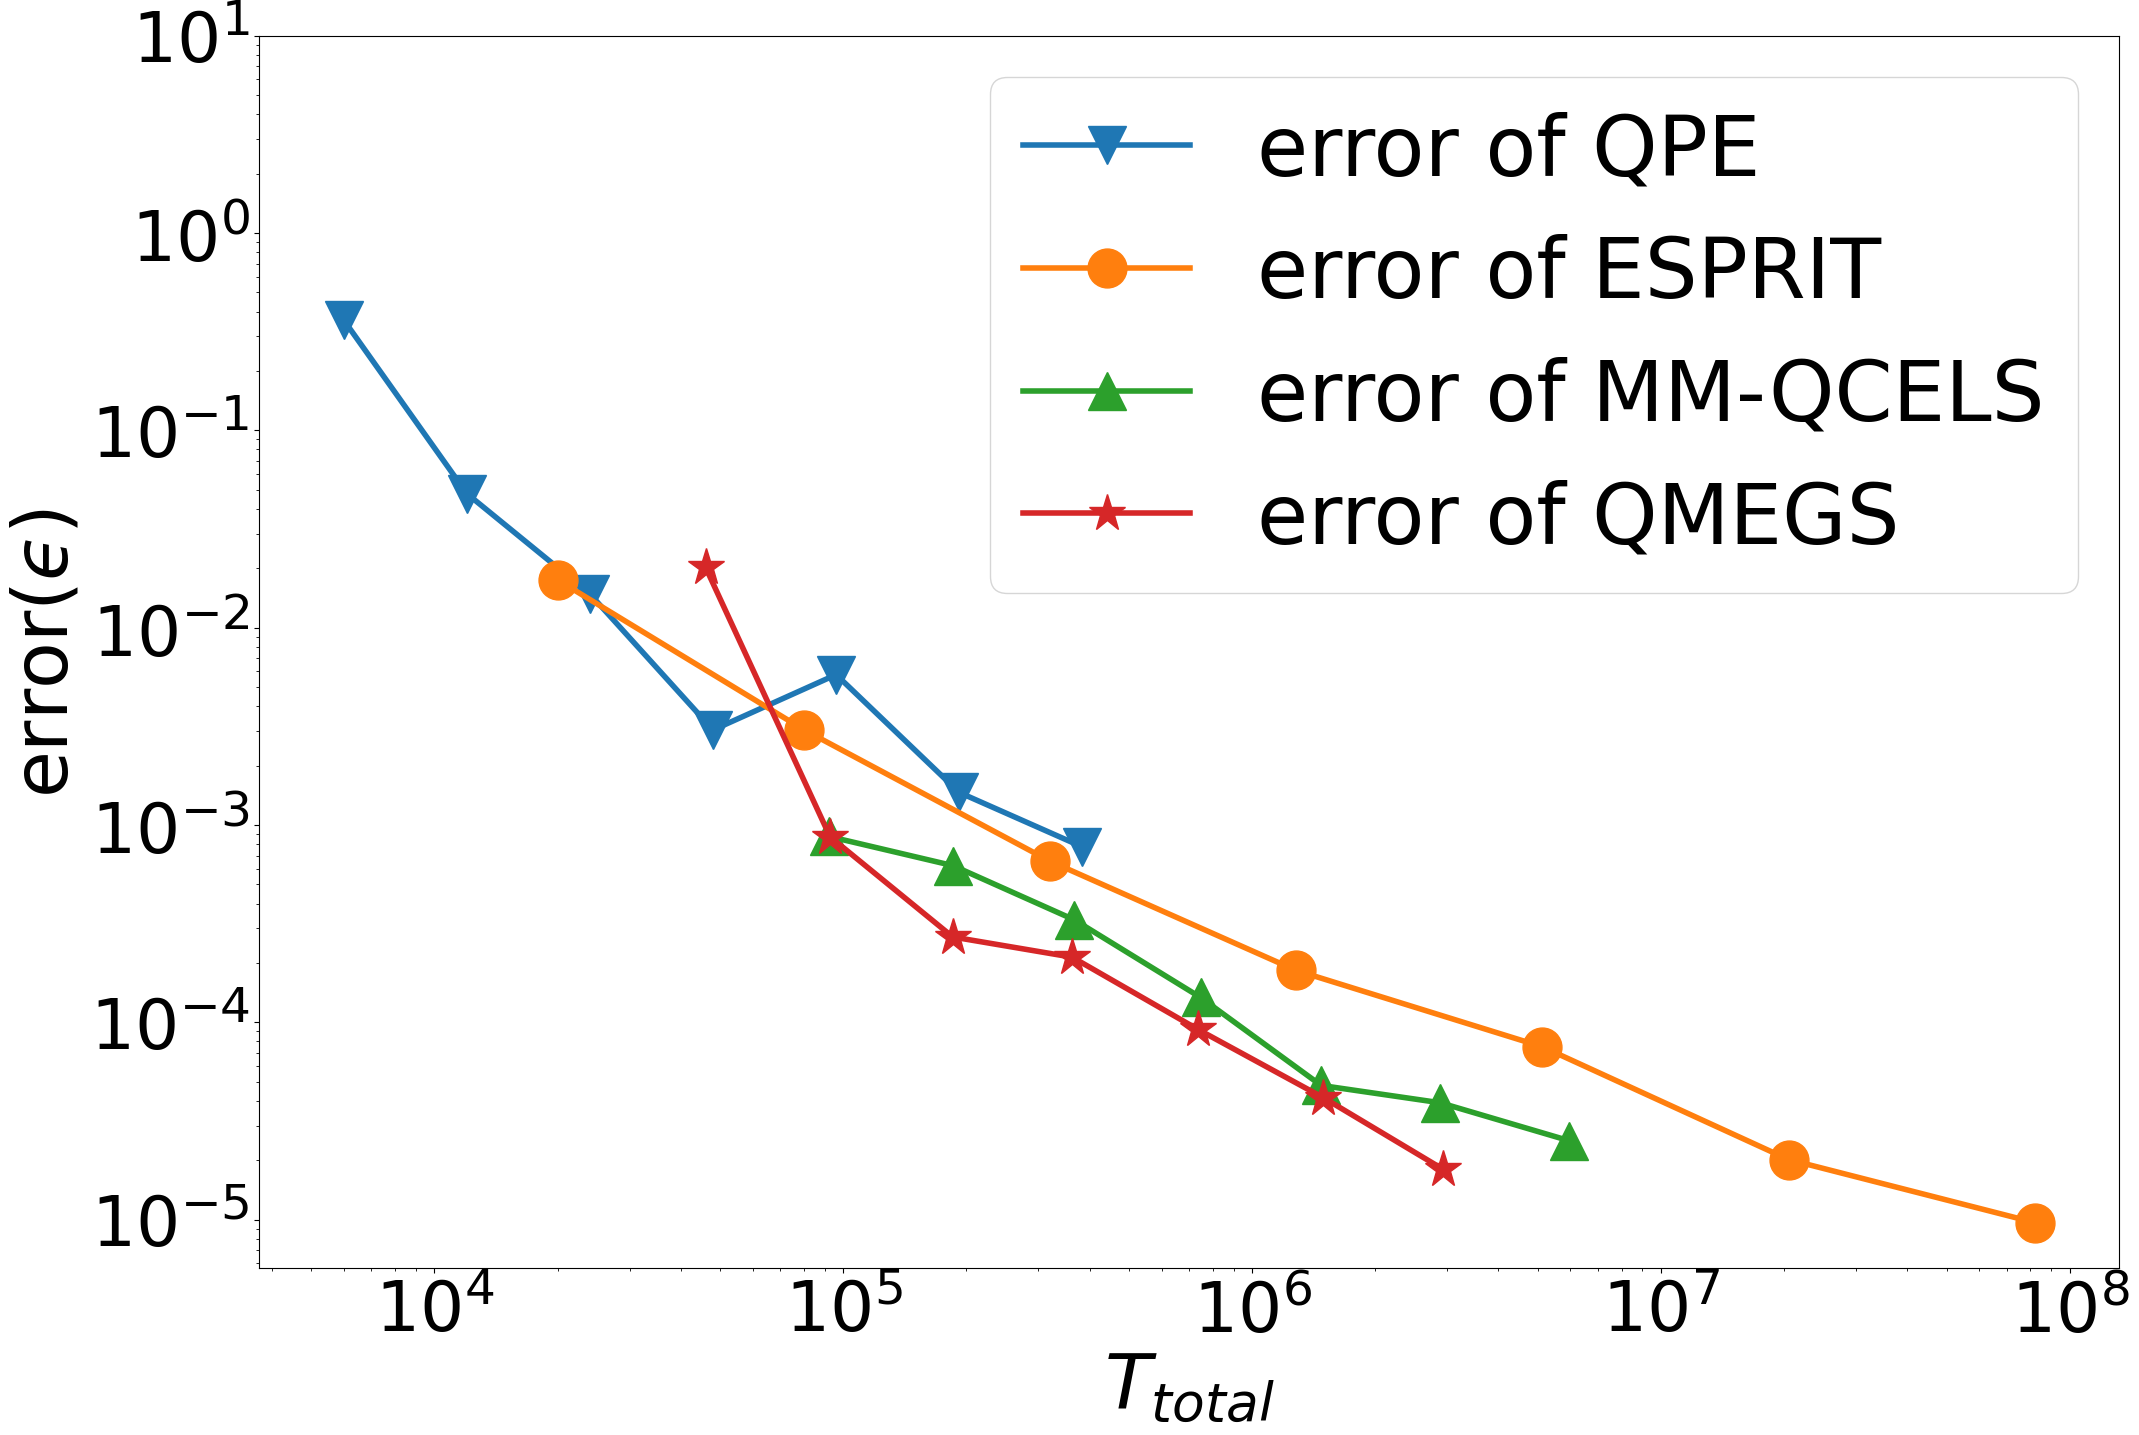

In [15]:
# Plotting the real and imaginary parts of f(t)
T_list=dt*nt_array
plt.figure(figsize=(24, 16))
plt.loglog(T_total_QPE, error_QPE, marker="v",markersize=28,
            linewidth=4, label='error of QPE')
plt.loglog(T_total_ESPRIT, error_ESPRIT, marker="o",markersize=28,
           linewidth=4, label='error of ESPRIT')
plt.loglog(T_total_QCELS, error_QCELS, marker="^",markersize=28,
           linewidth=4, label='error of MM-QCELS')
plt.loglog(T_total_QMEGS, error_QMEGS, marker="*",markersize=28,
           linewidth=4, label='error of QMEGS')
plt.xlabel("$T_{total}$",fontsize=55)
plt.ylabel("error($ϵ$)",fontsize=55)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=60)
plt.savefig('Hubbard_T_total.pdf')